In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean
from numpy.random import seed
from numpy.random import randint
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

#### Load Dataset

In [2]:
data= pd.read_csv("data.csv")
labels = pd.read_csv("labels.csv")

## Exploratory Data Analysis (EDA)

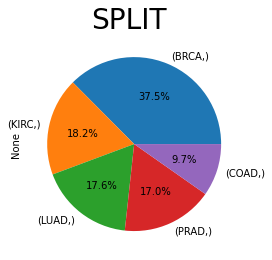

In [3]:
# Checking dataset for null values
data.isnull().sum()
labels.isnull().sum()

# Removing the unwanted first coloumn form both the CSV files for - data and labels
new_data = data.iloc[: , 1:]
new_label = labels.iloc[: , 1:]

# Visualizing class labels to understand sample distribution
new_label.value_counts()
new_label.value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.suptitle('SPLIT', size=28)
plt.show()


In [4]:
# Assiging altetred datasets for all uses beyond this point
X = new_data
y = new_label.values.ravel()

## Multidimensional data visualization 

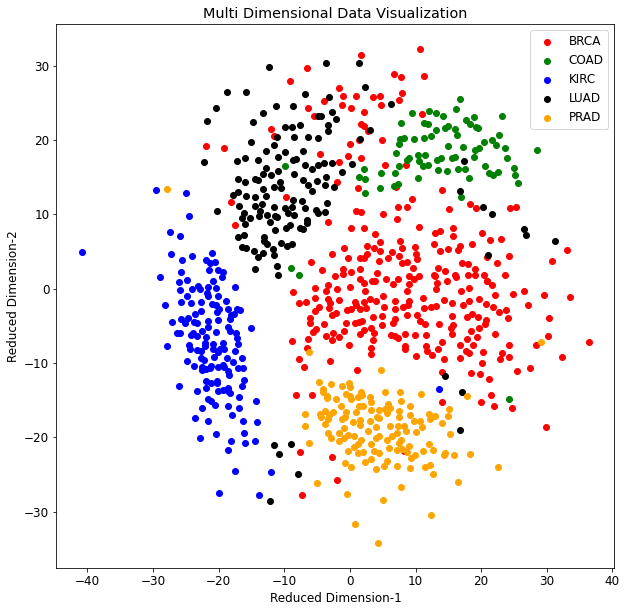

In [20]:
# Data - only the features are used here not the labels
X_MDS = new_data 

# Scalling - to be able to use MultiDimensionalScaling(MDS)
scaler_MDS = MinMaxScaler()
X_MDS_scaled = scaler_MDS.fit_transform(X_MDS)

# Reducing features from 20531 to 2, to be able to plot and visualise data
mds = MDS(2,random_state=0)
X_2D = mds.fit_transform(X_MDS_scaled)

# Transformed data is converted to arrays to use for plotting
first_coloumn,second_coloumn = zip(*X_2D)
col_1 = np.asarray(first_coloumn)
col_2 = np.asarray(second_coloumn)
col_1.shape = (801,1)
col_2.shape = (801,1)
colors = ['red','green','blue','black','orange']
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('font', size=12)
loop_count = 0
for i in np.unique(new_label):
    subset1 = col_1[new_label == i]
    subset2 = col_2[new_label == i]
    x = subset1
    y = subset2
    plt.scatter(x,y,c=colors[loop_count],label=i)
    loop_count = loop_count + 1
    
# Plot data    
plt.legend()
plt.title("Multi Dimensional Data Visualization")
plt.xlabel("Reduced Dimension-1")
plt.ylabel("Reduced Dimension-2")
plt.show()


## Feature Selection - MutualInformation

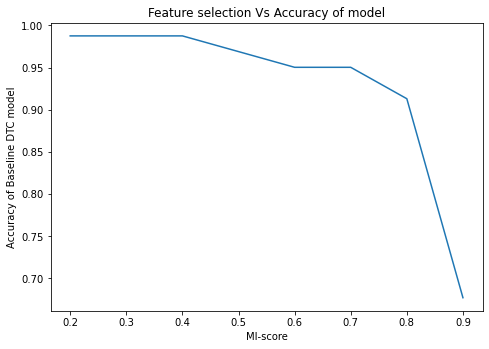

In [5]:
# MI-Score Calculation
mi_score = MIC(X,y)

# To find ideal value for MI-score threshold for feature selection
accuracy_plot_1 = []
mi_score_lvl = []
for i in range(2,10,1):
    n = i/10
    reduced_features_plot_1 = np.where(mi_score > n)[0]
    X_MI_plot_1 = X.iloc[:,reduced_features_plot_1]
    X_plot_train, X_plot_test, y_plot_train, y_plot_test = tts(X_MI_plot_1,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
    # no tuned parameters
    BaseModel_mi_plot = DTC().fit(X_plot_train,y_plot_train)
    score = BaseModel_mi_plot.score(X_plot_test,y_plot_test)
    accuracy_plot_1.append(score)
    mi_score_lvl.append(n)
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_axis_1 = mi_score_lvl
y_axis_1 = accuracy_plot_1
plt.plot(x_axis_1, y_axis_1)
plt.title('Feature selection Vs Accuracy of model')
plt.xlabel('MI-score')
plt.ylabel('Accuracy of Baseline DTC model')
plt.show()

# mi_score selection
reduced_features = np.where(mi_score > 0.5)[0]
reduced_features.shape
X_MI = X.iloc[:,reduced_features]


## Feature Selection - PrincipalComponentAnalysis (PCA)

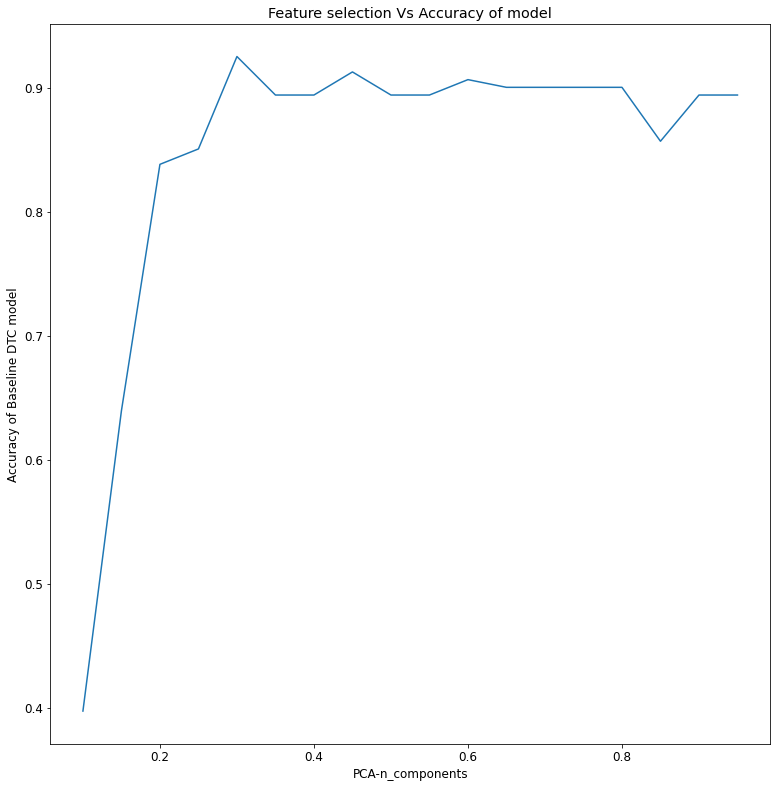

In [33]:
# PCA implementation
X_PCA = new_data
sc = StandardScaler()
X_PCA_std = sc.fit_transform(X_PCA)

# To find ideal value for n_components for feature selection
accuracy_plot_2 = []
pca_n_components = []
for i in range(10,100,5):
    n = i/100
    pca_plot_2 = decomposition.PCA(n_components=n) 
    X_PCA_applied_plot_2 = pca_plot_2.fit_transform(X_PCA_std)
    X_plot_train, X_plot_test, y_plot_train, y_plot_test = tts(X_PCA_applied_plot_2,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
    #no tuned parameters
    BaseModel_mi_plot = DTC().fit(X_plot_train,y_plot_train)
    score = BaseModel_mi_plot.score(X_plot_test,y_plot_test)
    accuracy_plot_2.append(score)
    pca_n_components.append(n)
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_axis_2 = pca_n_components
y_axis_2 = accuracy_plot_2
plt.plot(x_axis_2, y_axis_2)
plt.title('Feature selection Vs Accuracy of model')
plt.xlabel('PCA-n_components')
plt.ylabel('Accuracy of Baseline DTC model')
plt.show()

# n_components selection
pca = decomposition.PCA(n_components=0.95) #95% variance
X_PCA_applied = pca.fit_transform(X_PCA_std)


In [34]:
# To suppress "ignore" warnings during tuning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


## DT MODEL(default)

##### DT MODEL - Fature Selection : MutualInformation

In [35]:
X_DTC_mi_train, X_DTC_mi_test, y_DTC_mi_train, y_DTC_mi_test = tts(X_MI,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
                                    
BaseModel_mi = DTC().fit(X_DTC_mi_train,y_DTC_mi_train)
score = BaseModel_mi.score(X_DTC_mi_test,y_DTC_mi_test)
print(score)

0.9813664596273292


##### DT MODEL - Fature Extraction : PrincipalComponentAnalysis

In [36]:
X_DTC_pca_train, X_DTC_pca_test, y_DTC_pca_train, y_DTC_pca_test = tts(X_PCA_applied,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
BaseModel_pca = DTC().fit(X_DTC_pca_train,y_DTC_pca_train)
score = BaseModel_pca.score(X_DTC_pca_test,y_DTC_pca_test)
print(score)

0.8881987577639752


##### DT MODEL - Parameters : DTC_pca model

In [37]:
display(BaseModel_pca.get_params())
print("Number of leaves : ",BaseModel_pca.get_n_leaves())
print("Depth of DecisionTree : ",BaseModel_pca.get_depth())

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Number of leaves :  26
Depth of DecisionTree :  11


##### DT MODEL - Parameters : DTC_mi model

In [38]:
display(BaseModel_mi.get_params())
print("Number of leaves : ",BaseModel_mi.get_n_leaves())
print("Depth of DecisionTree : ",BaseModel_mi.get_depth())

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Number of leaves :  9
Depth of DecisionTree :  7


<b>FROM RUNNING COMPARISIONS BETWEEN "PCA" AND "MI" IT IS EVIDENT MI BASED FEATURE EXTRACTION IS BETER SUITED FOR THIS DATASET</b>

## TUNING DecisionTreeClassifier

## Primary HyperParameter tuning - using RandomizedSearchCV

In [ ]:
#Data
X_RS_train,X_RS_test,y_RS_train,y_RS_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

#Seed for reproducibility
seed(1)

#Parameters - RandomizedSearchCV
RS_parameters = {"criterion":("gini","entropy"),
              "max_depth":(randint(1,10),randint(1,10),randint(1,10),randint(1,10),None),
              "min_samples_leaf":[int(x) for x in np.linspace(start = 1, stop = 50, num = 10)],
              "min_samples_split":[int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              "random_state":(randint(1,10),randint(1,10),randint(1,10),randint(1,10),None),
              "max_leaf_nodes":(randint(1,10),randint(11,30),randint(31,100),randint(101,200),None),
              "min_impurity_decrease":[float(x) for x in np.linspace(start = 0.0, stop = 0.9, num = 20)],
              "splitter":("best","random"),
              "max_features":("auto","sqrt","log2",None),
              "class_weight":("balanced",None)
               }

#RandomizedSearchCV
RS_model = RandomizedSearchCV(estimator=DTC(),
                             param_distributions=RS_parameters,
                             n_jobs=-1,
                             n_iter=100,
                             random_state=2,
                             verbose=10)
RS_model.fit(X_RS_train,y_RS_train)

#Best tuned Parameters
print("tuned hyperparameters RS_CV: ",RS_model.best_params_)
print("tuned highest score RS_CV: ",RS_model.best_score_)

#Results
RS_modelresults = pd.DataFrame(RS_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
RS_modelresults = RS_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score',
           'split4_test_score',
           'std_test_score'
           ],
           axis=1)
RS_modelresults

RS_modelresults.head(10)


## Secondary HyperParameter tuning - using GridSearchCV
Obeservatios from the top 10 fields in Results of RandomizedSearchCV is used to analyze parameter range for GridSearchCV

In [ ]:
#Data
X_GS_train,X_GS_test,y_GS_train,y_GS_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

#Parameters - GridSearchCV
GS_parameters = { "splitter": ("random","best"),
               "random_state": (1,7,8,None),
               "min_samples_split": (10,30,40,50),
               "min_samples_leaf": (1,10,20,50),
               "min_impurity_decrease": (0.0,0.10,0.20,0.40),
               "max_leaf_nodes": (10,50,100,200,None),
               "max_features": ("auto",None),
               "max_depth": (2,4,6,8,10,None),
               "criterion": ("gini","entropy"),
               "class_weight": ("balanced",None),
             }

GS_model = GridSearchCV(DTC(), GS_parameters, cv=3, verbose = 10, n_jobs=-1)

GS_model.fit(X_GS_train, y_GS_train)

#Best tuned Parameters
print("tuned hyperparameters GS_CV: ",GS_model.best_params_)
print("tuned highest score GS_CV: ",GS_model.best_score_)

#Result
GS_modelresults = pd.DataFrame(GS_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
GS_modelresults = GS_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'std_test_score'
           ],
           axis=1)
GS_modelresults.head(5)

#Fitting model to best parameters
BestModelDTC_mi = DTC(min_samples_split=30,
                   min_samples_leaf=1,
                   max_features=None,
                   max_leaf_nodes=50,
                   min_impurity_decrease=0.0,
                   random_state=None,
                   splitter="random",
                   max_depth=10,
                   criterion="gini",
                   class_weight="balanced"
                  )
BestModelDTC_mi.fit(X_GS_train,y_GS_train)



## EVALUATION (DTC model_mi)

In [47]:
Eval_predict_DTC = BestModelDTC_mi.predict(X_GS_test)
confusion_matrix_DTC = pd.DataFrame(confusion_matrix(y_GS_test, Eval_predict_DTC), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_DTC)
print('Decision Tree Classifier Model: f1 score -', f1_score(y_GS_test, Eval_predict_DTC,average='macro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,15,0,1,0
LUAD,0,0,30,0,0
PRAD,1,0,1,26,0
COAD,0,0,0,0,27


Decision Tree Classifier Model: f1 score - 0.9777077151011095


## RF MODEL(default)

In [49]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

##### RF MODEL - Fature Extraction : MutualInformation

In [84]:
X_RF_mi_train, X_RF_mi_test, y_RF_mi_train, y_RF_mi_test = tts(X_MI,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
                                    
BaseModelRF_mi = rf.fit(X_RF_mi_train,y_RF_mi_train)
score = BaseModelRF_mi.score(X_RF_mi_test,y_RF_mi_test)
print(score)

0.9875776397515528


##### RF MODEL - Parameters : RF_mi

In [51]:
display(BaseModelRF_mi.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## TUNING RandomForestClassifier

## Primary HyperParameter tuning - using RandomizedSearchCV

In [ ]:
#Data
X_RS2_train,X_RS2_test,y_RS2_train,y_RS2_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)
#Seed for reproducibility
seed(1)

#Parameters for RandomizedSearchCV
RS2_parameters = {"n_estimators":[int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)],
              "criterion": ("gini","entropy"),   
              "max_depth":(randint(2,10),randint(1,10),randint(1,10),randint(1,10),None),
              "min_samples_split":[int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              "min_samples_leaf":[int(x) for x in np.linspace(start = 1, stop = 50, num = 10)],
              "min_weight_fraction_leaf": [float(x) for x in np.linspace(start = 0.0, stop = 0.5, num = 5)],
              "max_features":("auto","sqrt","log2"),
              "max_leaf_nodes":(randint(2,10),randint(11,40),randint(41,90),randint(91,150),None),
              "min_impurity_decrease":[float(x) for x in np.linspace(start = 0.0, stop = 0.9, num = 20)],
              "bootstrap": [True, False],
              "class_weight":("balanced","balanced_subsample",None)
               }

#RandomizedSearchCV
RS2_model = RandomizedSearchCV(estimator=RandomForestClassifier(),
                             param_distributions=RS2_parameters,
                             n_jobs=-1,
                             n_iter=100,
                             random_state=2,
                             verbose=10)
RS2_model.fit(X_RS2_train,y_RS2_train)

#Results
RS2_modelresults = pd.DataFrame(RS2_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
RS2_modelresults = RS2_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score',
           'split4_test_score',
           'std_test_score'
           ],
           axis=1)

RS2_modelresults.head(30)

#Best tuned Parameters
print("tuned hyperparameters RS_CV: ",RS2_model.best_params_)
print("tuned highest score RS_CV: ",RS2_model.best_score_)

## Secondary HyperParameter tuning - using GridSearchCV
Obeservatios from the top 30 fields in Results of RandomizedSearchCV is used to analyze parameter range for GridSearchCV

In [ ]:
#Data
X_GS2_train,X_GS2_test,y_GS2_train,y_GS2_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

#Parameters for GridSearchCV
GS2_parameters = {
              "n_estimators":(100,400,1000),
              "criterion": ("gini","entropy"),   
              "max_depth":(1,7,9,None),
              "max_features":("auto","sqrt","log2"),
              "max_leaf_nodes":(2,10,50,None),
              "bootstrap": [True, False],
              "class_weight":("balanced","balanced_subsample",None)
             }

#GridSearchCV
GS2_model = GridSearchCV(RandomForestClassifier(), GS2_parameters, cv=3, verbose = 10, n_jobs=-1)
GS2_model.fit(X_GS2_train, y_GS2_train)

#Results
GS2_modelresults = pd.DataFrame(GS2_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
GS2_modelresults = GS2_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
#            'split3_test_score',
#            'split4_test_score',
           'std_test_score'
           ],
           axis=1)

GS2_modelresults.head(5)

#Best tuned parameters
print("tuned hyperparameters GS_CV: ",GS2_model.best_params_)
print("tuned highest score GS_CV: ",GS2_model.best_score_)


#Best tuned Model selection & scoring
BestModelRF_mi = RandomForestClassifier(bootstrap=True,
                   class_weight="balanced",
                   criterion="gini",
                   max_depth=1,
                   max_features="auto",
                   max_leaf_nodes=50,
                   n_estimators=400
                  )

BestModelRF_mi.fit(X_GS2_train,y_GS2_train)



## EVALUATION (RF model_mi)

In [54]:
Eval_predict_RF = BestModelRF_mi.predict(X_GS2_test)
confusion_matrix_RF = pd.DataFrame(confusion_matrix(y_GS2_test, Eval_predict_RF), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_RF)
print('Random Forest Classifier Model: f1 score -', f1_score(y_GS2_test, Eval_predict_RF,average='macro'))


,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,30,0,0
PRAD,2,0,0,26,0
COAD,0,0,0,0,27


Random Forest Classifier Model: f1 score - 0.9893139040680025


## KNN MODEL(default)

In [56]:
knn = KNeighborsClassifier()

##### KNN MODEL - Fature Extraction : MutualInformation

In [57]:
X_KNN_mi_train, X_KNN_mi_test, y_KNN_mi_train, y_KNN_mi_test = tts(X_MI,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
                                    
BaseModelKNN_mi = knn.fit(X_KNN_mi_train,y_KNN_mi_train)
score = BaseModelKNN_mi.score(X_KNN_mi_test,y_KNN_mi_test)
print(score)

0.9937888198757764


##### KNN MODEL - Parameters : KNN_mi

In [58]:
display(BaseModelKNN_mi.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

## TUNING KNNClassifier

## Primary HyperParameter tuning - using RandomizedSearchCV

In [ ]:
#Data
X_RS3_train,X_RS3_test,y_RS3_train,y_RS3_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

#Normalising data for better results
X_scaled_RS3_train = sc.fit_transform(X_RS3_train)
X_scaled_RS3_test = sc.fit_transform(X_RS3_test)

#Seed for reproducibility
seed(1)

#Parameters for RandomizedSearchCV
RS3_parameters = {"n_neighbors":[int(x) for x in np.linspace(start = 1, stop = 200, num = 1)],
              "weights":("uniform","distance"),
              "algorithm":("auto","ball_tree","kd_tree","brute"),
              "leaf_size":[int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
              "p":[int(x) for x in np.linspace(start = 1, stop = 10, num = 1)],
              "metric":("euclidean","manhattan","minkowski","seuclidean")
               }

#RandomizedSearchCV
RS3_model = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                             param_distributions=RS3_parameters,
                             n_jobs=-1,
                             n_iter=100,
                             random_state=2,
                             verbose=10)
RS3_model.fit(X_scaled_RS3_train,y_RS3_train)

#Results
RS3_modelresults = pd.DataFrame(RS3_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
RS3_modelresults = RS3_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score',
           'split4_test_score',
           'std_test_score'
           ],
           axis=1)

RS3_modelresults.head(10)

#Best tuned Parameters
print("tuned hyperparameters RS_CV: ",RS3_model.best_params_)
print("tuned highest score RS_CV: ",RS3_model.best_score_)

## Secondary HyperParameter tuning - using GridSearchCV
Obeservatios from the top 10 fields in Results of RandomizedSearchCV is used to analyze parameter range for GridSearchCV

In [59]:
#Data
X_GS3_train,X_GS3_test,y_GS3_train,y_GS3_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

#Normalising data for better results
X_scaled_GS3_train = sc.fit_transform(X_GS3_train)
X_scaled_GS3_test = sc.fit_transform(X_GS3_test)

#Parameters for GridSearchCV
GS3_parameters = { "n_neighbors":[int(x) for x in np.linspace(start = 1, stop = 200, num = 1)],
              "weights":("uniform","distance"),
              "algorithm":("auto","ball_tree","kd_tree","brute"),
              "leaf_size":[int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
              "p":[int(x) for x in np.linspace(start = 1, stop = 10, num = 1)],
              "metric":("euclidean","manhattan","minkowski","seuclidean")
             }

#GridSearchCV
GS3_model = GridSearchCV(KNeighborsClassifier(), GS3_parameters, cv=3, verbose = 10, n_jobs=-1)
GS3_model.fit(X_scaled_GS3_train, y_GS3_train)

#Results
GS3_modelresults = pd.DataFrame(GS3_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
GS3_modelresults = GS3_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'std_test_score'
           ],
           axis=1)

GS3_modelresults.head(5)

#Best tuned parameters
print("tuned hyperparameters GS_CV: ",GS3_model.best_params_)
print("tuned highest score GS_CV: ",GS3_model.best_score_)

#Best tuned Model selection & scoring
BestModelKNN_mi = KNeighborsClassifier(algorithm="auto",
                   leaf_size=1,
                   metric="euclidean",
                   n_neighbors=1,
                   p=1,
                   weights="uniform"
                  )
BestModelKNN_mi.fit(X_scaled_GS3_train,y_GS3_train)



## EVALUATION (KNN model_mi)

In [61]:
Eval_predict_KNN = BestModelKNN_mi.predict(X_scaled_GS3_test)
confusion_matrix_KNN = pd.DataFrame(confusion_matrix(y_GS3_test, Eval_predict_KNN), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_KNN)
print('KNN Classifier Model: f1 score -', f1_score(y_GS3_test, Eval_predict_KNN,average='macro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,30,0,0
PRAD,1,0,0,27,0
COAD,0,0,0,0,27


KNN Classifier Model: f1 score - 0.994710743801653


## FINALISED MODEL 
After comparing DecisionTreeClassifier and RandomeForrestClassifier (the two selected classifiers for this classification task) with KNeighborsClassifier, it can be concluded based on "F1-score" that - Random Forest Classifier is the best model for this dataset

###### Model performance on Original Dataset

In [10]:
# Original Dataset; X & y
X_train,X_test,y_train,y_test = tts(X,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

#Selected classifier for Gene_Task
SelectedModel = RandomForestClassifier(bootstrap=True,
                   class_weight="balanced",
                   criterion="gini",
                   max_depth=1,
                   max_features="auto",
                   max_leaf_nodes=50,
                   n_estimators=400
                  )
SelectedModel.fit(X_train,y_train)

#Evaluating model performance
Eval_predict = SelectedModel.predict(X_test)
confusion_matrix_model = pd.DataFrame(confusion_matrix(y_test, Eval_predict), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_model)
print('Random Forest Classifier Model: f1 score -', f1_score(y_test, Eval_predict,average='macro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,30,0,0
PRAD,1,0,0,27,0
COAD,0,0,0,0,27


Random Forest Classifier Model: f1 score - 0.994710743801653


In [8]:
X.shape

(801, 20531)

In [9]:
X_MI.shape

(801, 478)

###### Model performance on Reduced Dataset

###### Without Cross Validation

In [11]:
# Reduced Dataset; X_MI(MI reduced dataset) & y
X_train,X_test,y_train,y_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

#Selected classifier for Gene_Task
SelectedModel = RandomForestClassifier(bootstrap=True,
                   class_weight="balanced",
                   criterion="gini",
                   max_depth=1,
                   max_features="auto",
                   max_leaf_nodes=50,
                   n_estimators=400
                  )
SelectedModel.fit(X_train,y_train)

#Evaluating model performance
Eval_predict = SelectedModel.predict(X_test)
confusion_matrix_model = pd.DataFrame(confusion_matrix(y_test, Eval_predict), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_model)
print('Random Forest Classifier Model: f1 score -', f1_score(y_test, Eval_predict,average='macro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,30,0,0
PRAD,2,0,0,26,0
COAD,0,0,0,0,27


Random Forest Classifier Model: f1 score - 0.9893139040680025


## CROSS VALIDATION

### K-Fold

In [65]:
X_validation = X_MI
y_validation = new_label
i_fold = [3, 5, 7]
for n in i_fold:
    cv = KFold(n_splits=n, random_state=1, shuffle=True)
    model = SelectedModel
    scores = cross_val_score(model, X_validation, y_validation, scoring='f1_macro', cv=cv, n_jobs=-1)
    print(' Fold: %d ; f1-score: %.3f' % (n, mean(scores)))

 Fold: 3 ; f1-score: 0.992
 Fold: 5 ; f1-score: 0.996
 Fold: 7 ; f1-score: 0.994


### Leave-One-Out

In [67]:
cv2 = LeaveOneOut()
model2 = SelectedModel
scores2 = cross_val_score(model2, X_validation, y_validation, scoring='f1_macro', cv=cv2, n_jobs=-1)
print('f1-score: %.3f' % (mean(scores2)))

f1-score: 0.994


## Data Augmentation

#### Using SMOTE - to address class imbalance 

AUGMENTED DATASET-1

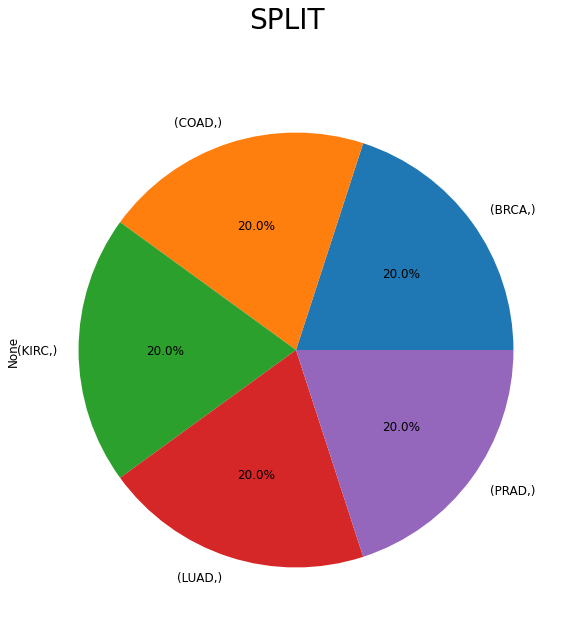

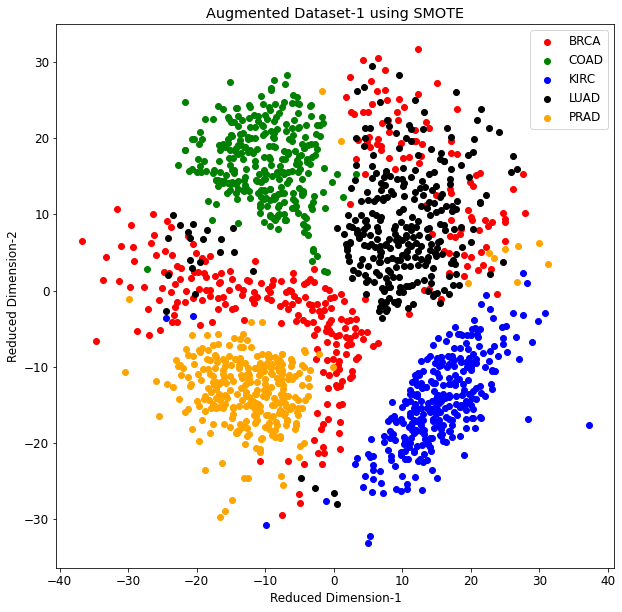

In [69]:
# Augmenting dataset using SMOTE
X_reshaped,y_reshaped = SMOTE().fit_resample(new_data,new_label)

# New sample composition
y_reshaped.value_counts()

# Visualizing class distribution
y_reshaped.value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.suptitle('SPLIT', size=28)
plt.show()

# Data - only the features are used here not the labels
X_MDS_D1 = X_reshaped 

# Scalling - to be able to use MultiDimensionalScaling(MDS)
scaler_MDS_D1 = MinMaxScaler()
X_MDS_scaled_D1 = scaler_MDS_D1.fit_transform(X_MDS_D1)

# Reducing features from 20531 to 2, to be able to plot and visualise data
mds_D1 = MDS(2,random_state=0)
X_2D_D1 = mds_D1.fit_transform(X_MDS_scaled_D1)

# Transformed data is converted to arrays to use for plotting
first_coloumn_D1,second_coloumn_D1 = zip(*X_2D_D1)
col_1_D1 = np.asarray(first_coloumn_D1)
col_2_D1 = np.asarray(second_coloumn_D1)
col_1_D1.shape = (1500,1)
col_2_D1.shape = (1500,1)
colors = ['red','green','blue','black','orange']
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('font', size=12)
loop_count = 0
for i in np.unique(y_reshaped):
    subset1 = col_1_D1[y_reshaped == i]
    subset2 = col_2_D1[y_reshaped == i]
    x = subset1
    y = subset2
    plt.scatter(x,y,c=colors[loop_count],label=i)
    loop_count = loop_count + 1
    
# Plot data    
plt.legend()
plt.title("Augmented Dataset-1 using SMOTE")
plt.xlabel("Reduced Dimension-1")
plt.ylabel("Reduced Dimension-2")
plt.show()

AUGMENTED DATASET-2

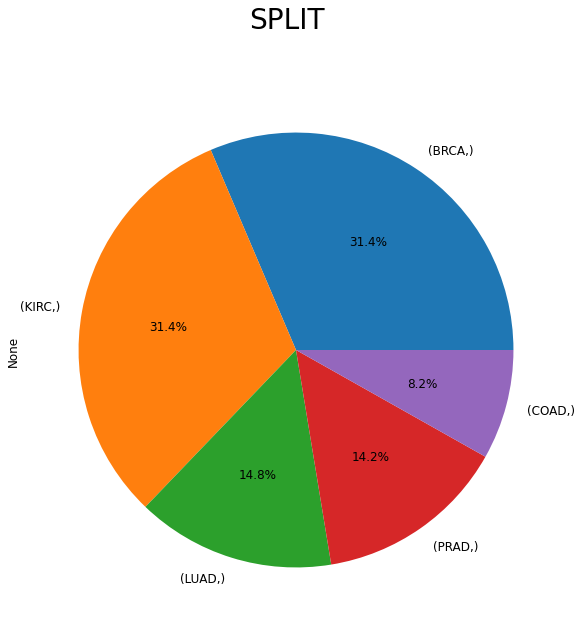

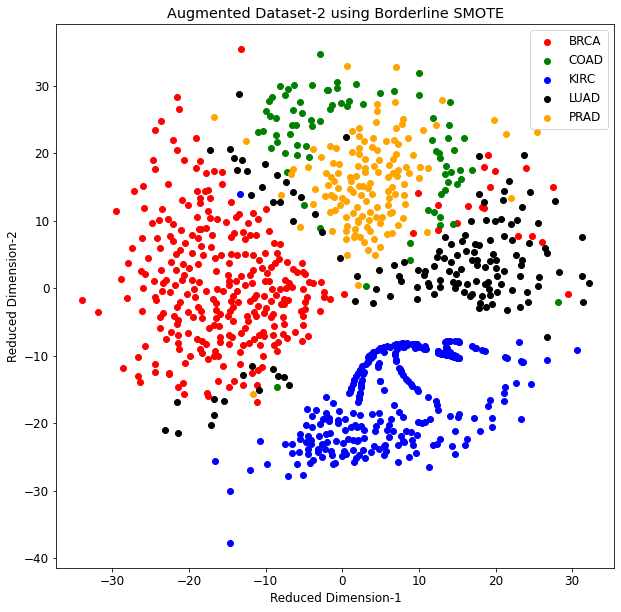

In [70]:
#Augmenting dataset using BorderlineSMOTE
X_reshaped2,y_reshaped2 = BorderlineSMOTE().fit_resample(new_data,new_label)

# New sample composition
y_reshaped2.value_counts()

# Visualizing class distribution
y_reshaped2.value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.suptitle('SPLIT', size=28)
plt.show()

# Data - only the features are used here not the labels
X_MDS_D2 = X_reshaped2

# Scalling - to be able to use MultiDimensionalScaling(MDS)
scaler_MDS_D2 = MinMaxScaler()
X_MDS_scaled_D2 = scaler_MDS_D2.fit_transform(X_MDS_D2)

# Reducing features from 20531 to 2, to be able to plot and visualise data
mds_D2 = MDS(2,random_state=0)
X_2D_D2 = mds_D2.fit_transform(X_MDS_scaled_D2)

# Transformed data is converted to arrays to use for plotting
first_coloumn_D2,second_coloumn_D2 = zip(*X_2D_D2)
col_1_D2 = np.asarray(first_coloumn_D2)
col_2_D2 = np.asarray(second_coloumn_D2)
col_1_D2.shape = (955,1)
col_2_D2.shape = (955,1)
colors = ['red','green','blue','black','orange']
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('font', size=12)
loop_count = 0
for i in np.unique(y_reshaped2):
    subset1 = col_1_D2[y_reshaped2 == i]
    subset2 = col_2_D2[y_reshaped2 == i]
    x = subset1
    y = subset2
    plt.scatter(x,y,c=colors[loop_count],label=i)
    loop_count = loop_count + 1
    
# Plot data    
plt.legend()
plt.title("Augmented Dataset-2 using Borderline SMOTE")
plt.xlabel("Reduced Dimension-1")
plt.ylabel("Reduced Dimension-2")
plt.show()

#### MODEL PERFORMANCE WITH DATASET-1

In [71]:
#Restructing label data
y_changed = y_reshaped.values.ravel()

#Data
X_augmented_train,X_augmented_test,y_augmented_train,y_augmented_test = tts(X_reshaped,y_changed, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y_changed)


#Model fitted on training data
SelectedModel.fit(X_augmented_train,y_augmented_train)

#Evaluating performace of model on augmented Dataset1
Eval_predict_DS1 = SelectedModel.predict(X_augmented_test)
confusion_matrix_model_DS1 = pd.DataFrame(confusion_matrix(y_augmented_test, Eval_predict_DS1), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_model_DS1)
print('Random Forest Classifier Model on Augmented Dataset-1: f1 score -', f1_score(y_augmented_test, Eval_predict_DS1,average='macro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,60,0,0,0
LUAD,0,0,60,0,0
PRAD,2,0,0,58,0
COAD,0,0,0,0,60


Random Forest Classifier Model on Augmented Dataset-1: f1 score - 0.9933314809669354


#### MODEL PERFORMANCE WITH DATASET-2

In [72]:
#Restructing label data
y_changed2 = y_reshaped2.values.ravel()

#Data
X_augmented2_train,X_augmented2_test,y_augmented2_train,y_augmented2_test = tts(X_reshaped2,y_changed2, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y_changed2)

#Model fitted on training data
SelectedModel.fit(X_augmented2_train,y_augmented2_train)

#Evaluating performace of model on augmented Dataset2
Eval_predict_DS2 = SelectedModel.predict(X_augmented2_test)
confusion_matrix_model_DS2 = pd.DataFrame(confusion_matrix(y_augmented2_test, Eval_predict_DS2), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_model_DS2)
print('Random Forest Classifier Model on Augmented Dataset-1: f1 score -', f1_score(y_augmented2_test, Eval_predict_DS2,average='macro'))



,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,60,0,0
PRAD,0,1,0,27,0
COAD,0,0,0,0,27


Random Forest Classifier Model on Augmented Dataset-1: f1 score - 0.9903030303030302


## ENSEMBLE

VOTING BASED

In [87]:
# A list to hold all the models
estimators = []

model_1 = DTC(min_samples_split=30,
                   min_samples_leaf=1,
                   max_features=None,
                   max_leaf_nodes=50,
                   min_impurity_decrease=0.0,
                   random_state=None,
                   splitter="random",
                   max_depth=10,
                   criterion="gini",
                   class_weight="balanced"
                  )

estimators.append(('Decision Tree', model_1))

model_2 = RandomForestClassifier(bootstrap=True,
                   class_weight="balanced",
                   criterion="gini",
                   max_depth=1,
                   max_features="auto",
                   max_leaf_nodes=50,
                   n_estimators=400
                  )

estimators.append(('Random Forest', model_2))

model_3 = KNeighborsClassifier(algorithm="auto",
                   leaf_size=1,
                   metric="euclidean",
                   n_neighbors=1,
                   p=1,
                   weights="uniform"
                  )

estimators.append(('KNN', model_3))

# Ensemble by voting
ensemble = VotingClassifier(estimators)

# Evaluation
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
result = model_selection.cross_val_score(ensemble, X_MI,y, cv=kfold)

print(result.mean())

0.9962500000000001
